# KeyPoint-MoSeq Behavioral Analysis Pipeline

This notebook demonstrates the complete KeyPoint-MoSeq (KPMS) pipeline for discovering behavioral syllables from pose estimation data. The pipeline:

1. **Loads and formats** pose data from CSV files
2. **Performs PCA** for dimensionality reduction
3. **Fits AR-HMM model** to discover behavioral syllables
4. **Generates visualizations** including trajectory plots and behavioral movies

## Data Setup
- Place your H5 pose files in `data/` directory
- Or convert them to CSV format using the preprocessing functions
- Update the paths in the configuration section below 

## Environment Setup

Setting environment variables to optimize JAX GPU memory usage:
- `XLA_PYTHON_CLIENT_PREALLOCATE=false`: Prevents JAX from pre-allocating all GPU memory
- `XLA_PYTHON_CLIENT_ALLOCATOR=platform`: Uses platform-specific memory allocation

This configuration provides more available GPU memory at the cost of slightly slower computation.


In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax
print(jax.devices()[0].platform)

gpu


## Import Libraries

Import the necessary libraries and our custom pipeline modules.

In [5]:
# Standard library imports
import sys, os 
import pathlib
import logging

# Add project root to Python path for our modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [6]:
# Import our simplified pipeline modules
from src.utils import set_up_logging, print_gpu_usage, validate_data_quality
from src.methods import load_and_format_data, perform_pca, fit_and_save_model, generate_plots_and_movies
from src.preprocessing import h5_to_csv_poses

In [7]:
# KeyPoint-MoSeq imports
import keypoint_moseq as kpms
from jax_moseq.utils import set_mixed_map_iters

In [8]:
import jax
print(jax.devices()[0].platform)


gpu


## Configuration Parameters

Set the key parameters for your analysis. Adjust these based on your data and computational resources.

In [9]:
# Model training parameters
G_MIXED_MAP_ITERS = 8          # Reduce if running out of GPU memory
G_ARHMM_ITERS = 400            # Number of AR-HMM iterations (reduced for research)
G_FULL_MODEL_ITERS = 400       # Number of full model iterations (reduced for research) 
G_KAPPA = 0.1                  # Stickiness parameter (0.1 is good default for research)


In [10]:
# Configure GPU memory usage for model training
# Reduces GPU memory requirements at cost of computation time
set_mixed_map_iters(G_MIXED_MAP_ITERS)
print(f"Set mixed map iterations to {G_MIXED_MAP_ITERS} for GPU memory optimization")

Set mixed map iterations to 8 for GPU memory optimization


<div class="alert alert-block alert-info">
ⓘ As an example, I'm using examples folder but the data should ideally sit at data folder in this repository.
</div>

In [11]:
# Project paths - UPDATE THESE FOR YOUR DATA
G_BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Auto-detect project root
G_PROJ_NAME = "LL1-B2B-analysis"                                      # Change this for your project
G_PROJ_PATH = os.path.join(G_BASE_PATH, "results", G_PROJ_NAME)
G_VIDEO_DIR = os.path.join(G_BASE_PATH, "data", "LL1-B2B", "videos")
G_POSE_DIR = os.path.join(G_BASE_PATH, "data", "LL1-B2B", "poses")

print(f"Project directory: {G_PROJ_PATH}")
print(f"Pose data directory: {G_POSE_DIR}")
print(f"Video directory: {G_VIDEO_DIR}")

Project directory: /projects/kumar-lab/miaod/experiments/kpms_kumarlab/results/LL1-B2B-analysis
Pose data directory: /projects/kumar-lab/miaod/experiments/kpms_kumarlab/data/LL1-B2B/poses
Video directory: /projects/kumar-lab/miaod/experiments/kpms_kumarlab/data/LL1-B2B/videos


In [12]:
# Setting body parts and skeleton for 12 keypoints, change accordingly if you have different number of keypoints
G_BODYPARTS = [
    "NOSE_INDEX",
    "LEFT_EAR_INDEX",
    "RIGHT_EAR_INDEX",
    "BASE_NECK_INDEX",
    "LEFT_FRONT_PAW_INDEX",
    "RIGHT_FRONT_PAW_INDEX",
    "CENTER_SPINE_INDEX",
    "LEFT_REAR_PAW_INDEX",
    "RIGHT_REAR_PAW_INDEX",
    "BASE_TAIL_INDEX",
    "MID_TAIL_INDEX",
    "TIP_TAIL_INDEX",
]

G_SKELETON = [
    ["TIP_TAIL_INDEX", "MID_TAIL_INDEX"],
    ["MID_TAIL_INDEX", "BASE_TAIL_INDEX"],
    ["BASE_TAIL_INDEX", "RIGHT_REAR_PAW_INDEX"],
    ["BASE_TAIL_INDEX", "LEFT_REAR_PAW_INDEX"],
    ["BASE_TAIL_INDEX", "CENTER_SPINE_INDEX"],
    ["CENTER_SPINE_INDEX", "LEFT_FRONT_PAW_INDEX"],
    ["CENTER_SPINE_INDEX", "RIGHT_FRONT_PAW_INDEX"],
    ["CENTER_SPINE_INDEX", "BASE_NECK_INDEX"],
    ["BASE_NECK_INDEX", "NOSE_INDEX"],
]


## Project Initialization

Initialize the KeyPoint-MoSeq project with the necessary configurations.

In [13]:

def initialize_project():
    """Initialize project settings and configurations for research analysis."""
    
    # Create project directory
    project_path = pathlib.Path(G_PROJ_PATH)
    
    # Set up KeyPoint-MoSeq project
    kpms.setup_project(
        project_path, 
        video_dir=G_VIDEO_DIR, 
        bodyparts=G_BODYPARTS, 
        skeleton=G_SKELETON
    )
    
    # Configure logging for research tracking
    log_dir = project_path / "logs"
    set_up_logging(log_dir)
    
    # Update project configuration for research needs
    kpms.update_config(
        project_path,
        anterior_bodyparts=["BASE_NECK_INDEX"],   # Adjust for your research focus
        posterior_bodyparts=["BASE_TAIL_INDEX"],  # Adjust for your research focus
        use_bodyparts=G_BODYPARTS,
    )
    
    logging.info(f"Project initialized: {project_path}")
    logging.info(f"GPU memory configuration: {G_MIXED_MAP_ITERS} mixed map iterations")
    
    return project_path

## Analysis Pipeline

Run the complete KeyPoint-MoSeq analysis pipeline on your data.

### Step 1: Data Preprocessing (Optional)

If you have H5 pose files, convert them to CSV format. Skip this step if you already have CSV files.

<div class="alert alert-block alert-warning">
⚠️ ONLY RUN THE FOLLOWING CELL ONCE TO INITIALIZE THE PROJECT
</div>

In [14]:
# # Initialize the project (run this once)
# project_path = initialize_project()

# # Define CSV output directory
# G_POSE_CSV_DIR = os.path.join(G_BASE_PATH, "data", "LL1-B2B", "poses_csv")

# # Create CSV directory if it doesn't exist
# os.makedirs(G_POSE_CSV_DIR, exist_ok=True)

# # Convert H5 to CSV if needed
# if os.listdir(G_POSE_CSV_DIR):
#     print(f"CSV files already exist in {G_POSE_CSV_DIR}")
#     logging.info("Skipping H5 to CSV conversion - files already exist")
# else:
#     print(f"Converting H5 files to CSV format...")
#     logging.info("Converting H5 pose files to CSV format")
#     try:
#         converted_files = h5_to_csv_poses(G_POSE_DIR, G_POSE_CSV_DIR)
#         print(f"Successfully converted {len(converted_files)} files")
#     except Exception as e:
#         print(f"Error during conversion: {e}")
#         logging.error(f"H5 to CSV conversion failed: {e}")

project_path = pathlib.Path(G_PROJ_PATH)
G_POSE_CSV_DIR = os.path.join(G_BASE_PATH, "data", "LL1-B2B", "poses_csv")

### Step 2: Run the Complete KPMS Pipeline

This cell runs the entire analysis pipeline: data loading, PCA, model fitting, and visualization generation.

Starting KeyPoint-MoSeq analysis pipeline...
Using device: gpu

=== Initial GPU Usage ===

=== Loading and Formatting Data ===


Loading keypoint files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:48<00:00,  2.08it/s]



=== Data Quality Report ===

=== GPU Usage After Data Loading ===

=== Performing PCA Analysis ===
>=90.0% of variance exlained by 5 components.


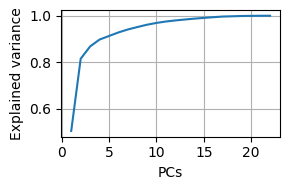

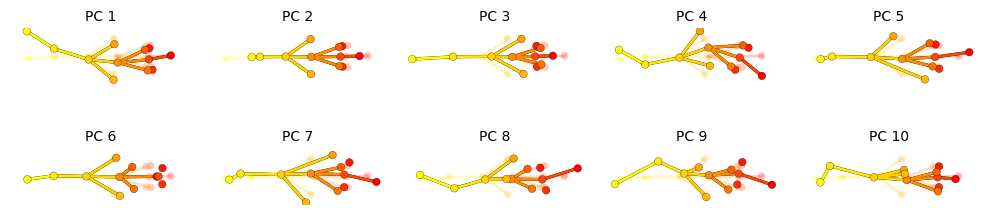

Updating latent dimension to 5 (components explaining >90% variance)

=== GPU Usage After PCA ===

=== Fitting AR-HMM Model (kappa=0.1) ===
Outputs will be saved to /projects/kumar-lab/miaod/experiments/kpms_ku
marlab/results/LL1-B2B-analysis/2025_06_09-18_24_38


  6%|██                                | 25/401 [02:27<36:34,  5.84s/it]

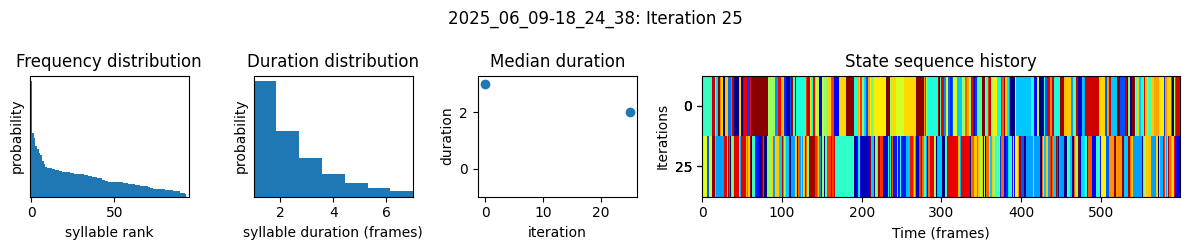

 12%|████▏                             | 50/401 [05:00<33:54,  5.80s/it]

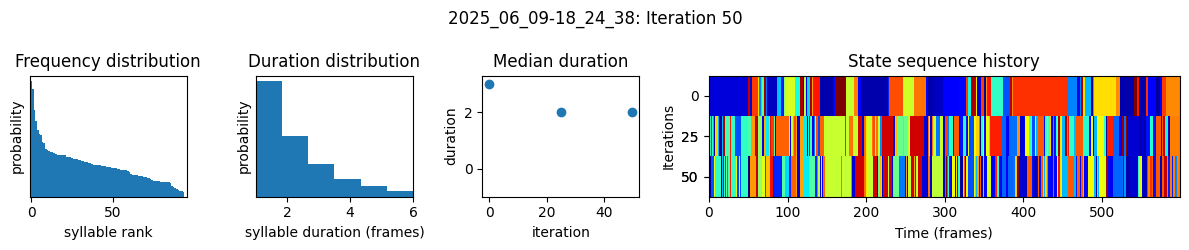

 19%|██████▎                           | 75/401 [07:33<31:38,  5.82s/it]

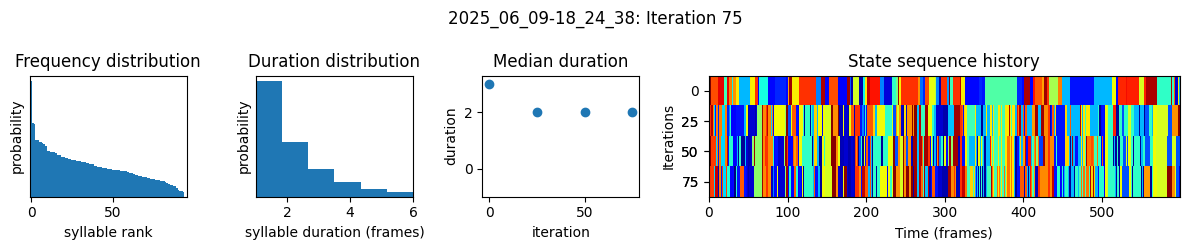

 25%|████████▏                        | 100/401 [10:06<29:02,  5.79s/it]

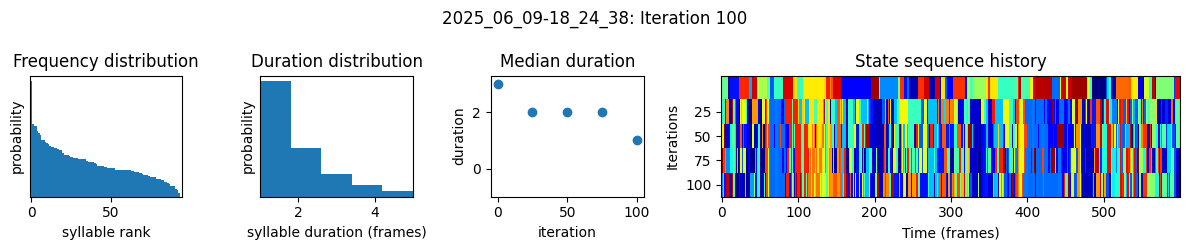

 31%|██████████▎                      | 125/401 [12:39<26:43,  5.81s/it]

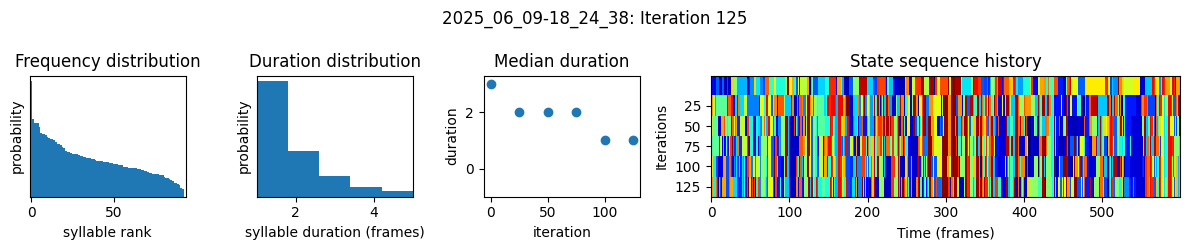

 37%|████████████▎                    | 150/401 [15:12<24:08,  5.77s/it]

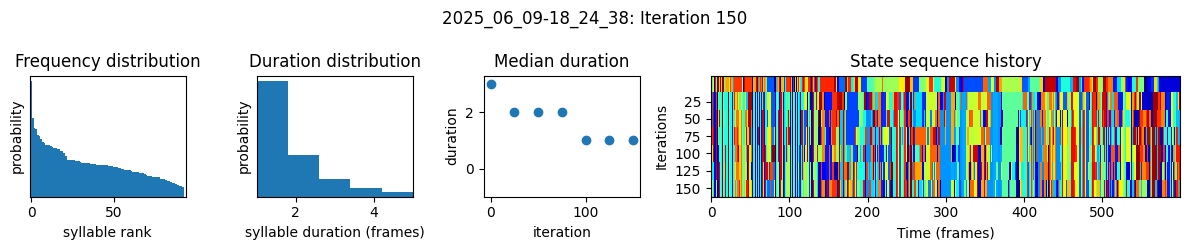

 44%|██████████████▍                  | 175/401 [17:45<21:46,  5.78s/it]

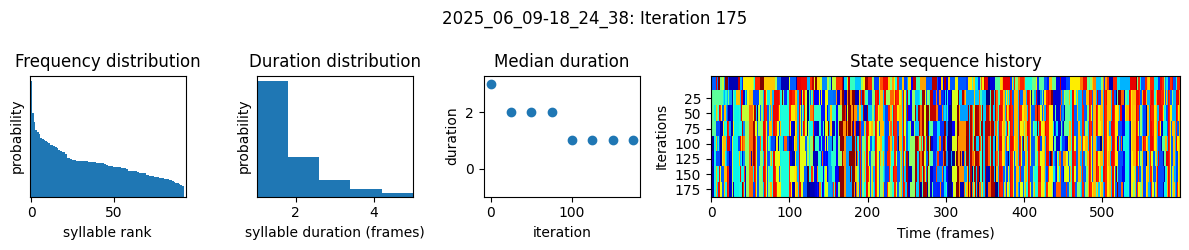

 50%|████████████████▍                | 200/401 [20:20<19:25,  5.80s/it]

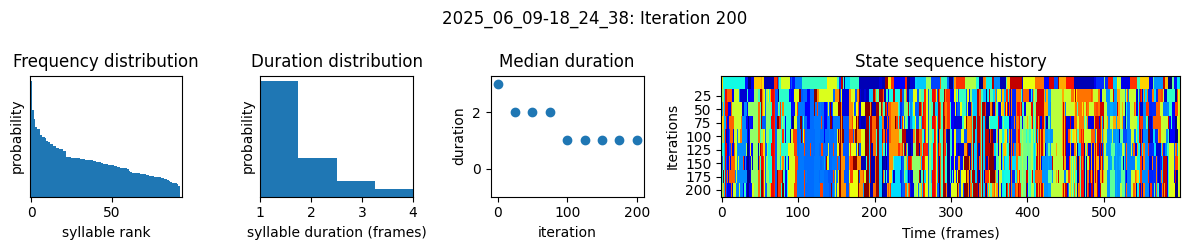

 56%|██████████████████▌              | 225/401 [22:54<17:05,  5.82s/it]

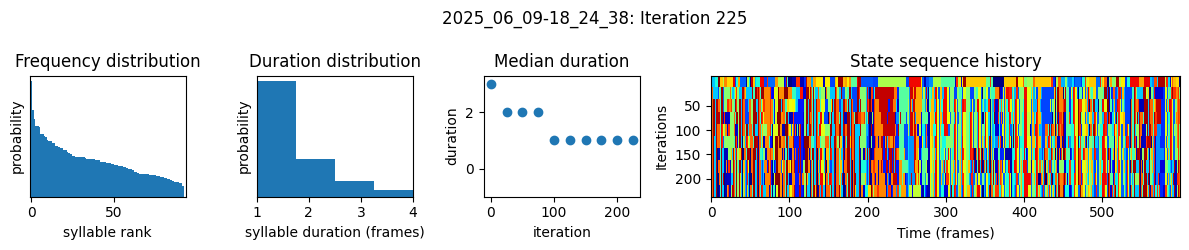

 62%|████████████████████▌            | 250/401 [25:29<14:30,  5.77s/it]

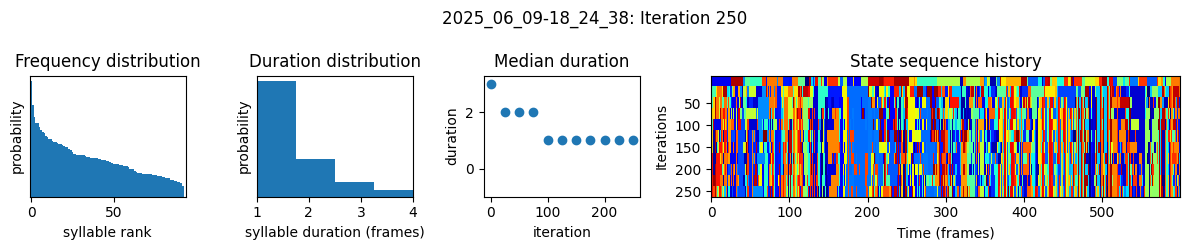

 69%|██████████████████████▋          | 275/401 [28:04<12:10,  5.79s/it]

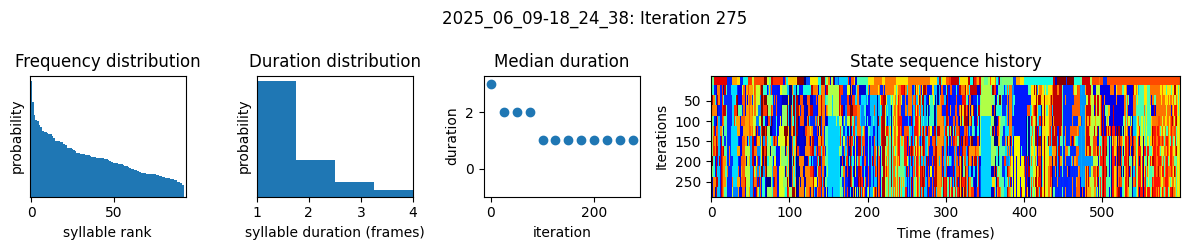

 75%|████████████████████████▋        | 300/401 [30:39<09:44,  5.79s/it]

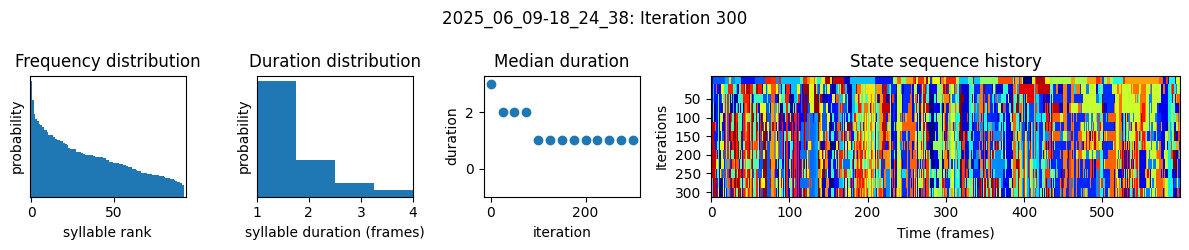

 81%|██████████████████████████▋      | 325/401 [33:14<07:21,  5.81s/it]

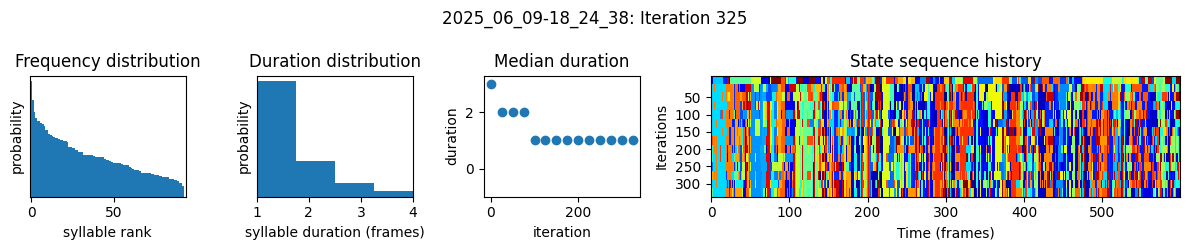

 87%|████████████████████████████▊    | 350/401 [35:49<04:55,  5.80s/it]

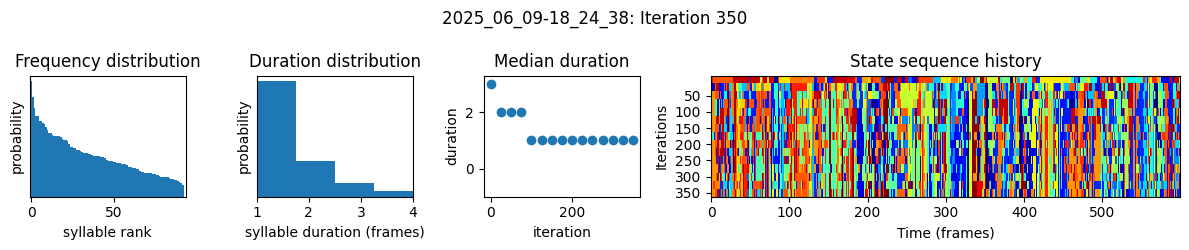

 94%|██████████████████████████████▊  | 375/401 [38:25<02:30,  5.79s/it]

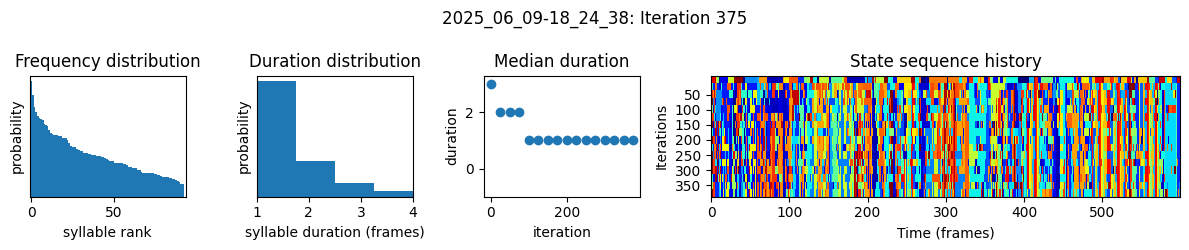

100%|████████████████████████████████▉| 400/401 [41:01<00:05,  5.86s/it]

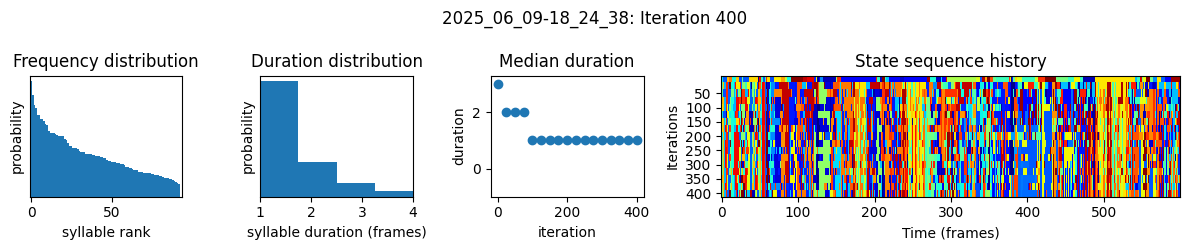

100%|█████████████████████████████████| 401/401 [41:18<00:00,  6.18s/it]


Outputs will be saved to /projects/kumar-lab/miaod/experiments/kpms_ku
marlab/results/LL1-B2B-analysis/2025_06_09-18_24_38


  6%|█▊                              | 23/401 [18:14<4:57:11, 47.17s/it]

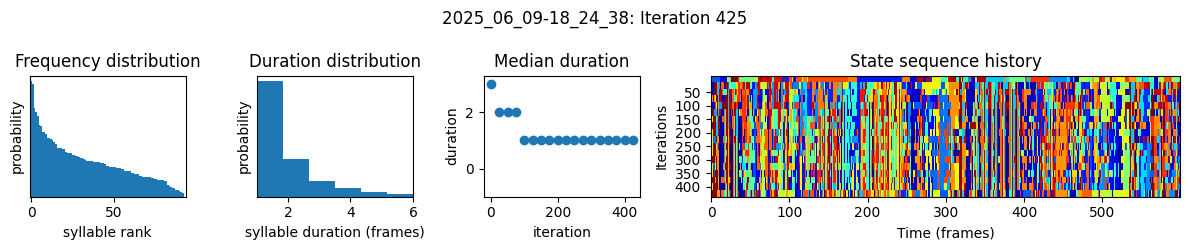

 11%|███▌                            | 44/401 [34:52<4:39:42, 47.01s/it]

In [ ]:
print("Starting KeyPoint-MoSeq analysis pipeline...")
print(f"Using device: {jax.devices()[0].platform}")

# Monitor GPU usage if available
if jax.devices()[0].platform != 'cpu':
    print("\n=== Initial GPU Usage ===")
    print_gpu_usage()

# Step 2a: Load and format data
print("\n=== Loading and Formatting Data ===")
data, metadata, coordinates = load_and_format_data(G_POSE_CSV_DIR, project_path)

# Validate data quality for research
print("\n=== Data Quality Report ===")
# quality_report = validate_data_quality(coordinates, metadata.get('confidences', {}))
# for filename, metrics in quality_report.items():
#     print(f"{filename}: {metrics['total_frames']} frames, "
#           f"mean confidence: {metrics['mean_confidence']:.3f}")

# Configuration function for KPMS
config_kpms = lambda: kpms.load_config(project_path)

if jax.devices()[0].platform != 'cpu':
    print("\n=== GPU Usage After Data Loading ===")
    print_gpu_usage()

# Step 2b: Perform PCA
print("\n=== Performing PCA Analysis ===")
pca, n_components_90 = perform_pca(data, config_kpms, project_path)

# Step 2b.1: Update config with optimal latent dimension
print(f"Updating latent dimension to {n_components_90} (components explaining >90% variance)")
kpms.update_config(project_path, latent_dim=n_components_90)

if jax.devices()[0].platform != 'cpu':
    print("\n=== GPU Usage After PCA ===")
    print_gpu_usage()

# Step 2c: Fit AR-HMM model
print(f"\n=== Fitting AR-HMM Model (kappa={G_KAPPA}) ===")
model, model_name, results = fit_and_save_model(
    data, metadata, pca, config_kpms, project_path, 
    kappa=G_KAPPA, 
    arhmm_iters=G_ARHMM_ITERS, 
    full_model_iters=G_FULL_MODEL_ITERS
)

# Step 2d: Generate visualizations
print("\n=== Generating Plots and Movies ===")
generate_plots_and_movies(model_name, results, coordinates, project_path, config_kpms)

print(f"\n=== Analysis Complete! ===")
print(f"Results saved to: {project_path}")
print(f"Model name: {model_name}")